In [3]:
import json
import pickle
import os
import zipfile

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from shutil import copyfile

sns.set_style("darkgrid")

In [4]:
#### Settings
### Learning Rate for CNN = 0.01, no learning rate decay

In [5]:
os.chdir("/home/bahy/research/icl-prelab-assignment/")

In [6]:
!pwd

/home/bahy/research/icl-prelab-assignment


In [7]:
datas = []
for file_name in glob("logs_q3/*.txt"):
    print(file_name)
    file = open(file_name, "rb")
    for data in file.readlines():
        if len(data) < 10: # Ignoring blank space/not useful information
            continue
        dict_data = eval(data)
        dict_data['setting'] = file_name.split("/")[1].split("-")[0]
        dict_data['E'] = file_name.split("/")[1].split("-")[2].replace("E", "")
        dict_data['model'] = file_name.split("/")[1].split("-")[-1].split(".")[0]
 
        datas.append(dict_data)
        
datas = pd.DataFrame(datas)

logs_q3/IID-B600-E1-C0.1-MNIST-CNN.txt
logs_q3/NONIID-B10-E1-C0.1-MNIST-CNN.txt
logs_q3/IID-B600-E20-C0.1-MNIST-CNN.txt
logs_q3/NONIID-B50-E1-C0.1-MNIST-CNN.txt
logs_q3/IID-B10-E20-C0.1-MNIST-CNN.txt
logs_q3/IID-B50-E1-C0.1-MNIST-CNN.txt
logs_q3/IID-B50-E20-C0.1-MNIST-CNN.txt
logs_q3/NONIID-B50-E20-C0.1-MNIST-CNN.txt
logs_q3/NONIID-B600-E20-C0.1-MNIST-CNN.txt
logs_q3/NONIID-B600-E1-C0.1-MNIST-CNN.txt
logs_q3/IID-B10-E1-C0.1-MNIST-CNN.txt
logs_q3/NONIID-B10-E20-C0.1-MNIST-CNN.txt


In [8]:
datas.head()

,C,B,comm_round,train_acc,test_acc,train_loss,test_loss,setting,E,model
0,0.1,600,1,0.0985,0.1023,2.2986,2.2978,IID,1,CNN
1,0.1,600,2,0.1060,0.1105,2.2952,2.2944,IID,1,CNN
2,0.1,600,3,0.1142,0.1198,2.2919,2.2911,IID,1,CNN
3,0.1,600,4,0.1220,0.1281,2.2887,2.2877,IID,1,CNN
4,0.1,600,5,0.1294,0.1330,2.2854,2.2844,IID,1,CNN


In [9]:
# Sort the data
ROUNDING_DIGIT = 4

df_metrics = datas.sort_values(by=['setting', 'B', 'E', 'comm_round']).reset_index(drop=True)
df_metrics = df_metrics[['setting', 'B', 'E', 'C', 'comm_round', 'train_acc', 'test_acc', 'train_loss', 'test_loss', 'model']]
df_metrics['train_acc'] = df_metrics['train_acc'].apply(lambda x: round(x, ROUNDING_DIGIT))
df_metrics['test_acc'] = df_metrics['test_acc'].apply(lambda x: round(x, ROUNDING_DIGIT))
df_metrics['train_loss'] = df_metrics['train_loss'].apply(lambda x: round(x, ROUNDING_DIGIT))
df_metrics['test_loss'] = df_metrics['test_loss'].apply(lambda x: round(x, ROUNDING_DIGIT))
df_metrics.head()

,setting,B,E,C,comm_round,train_acc,test_acc,train_loss,test_loss,model
0,IID,10,1,0.1,1,0.6006,0.6148,2.0736,2.0677,CNN
1,IID,10,1,0.1,2,0.7659,0.7795,1.3630,1.3437,CNN
2,IID,10,1,0.1,3,0.8295,0.8434,0.6980,0.6723,CNN
3,IID,10,1,0.1,4,0.8757,0.8815,0.4930,0.4735,CNN
4,IID,10,1,0.1,5,0.8888,0.8976,0.4061,0.3861,CNN


In [10]:
df_metrics.tail()

,setting,B,E,C,comm_round,train_acc,test_acc,train_loss,test_loss,model
11995,NONIID,600,20,0.1,996,0.8641,0.8676,0.3924,0.3817,CNN
11996,NONIID,600,20,0.1,997,0.8988,0.8990,0.2788,0.2746,CNN
11997,NONIID,600,20,0.1,998,0.9220,0.9256,0.2369,0.2273,CNN
11998,NONIID,600,20,0.1,999,0.9468,0.9502,0.1773,0.1652,CNN
11999,NONIID,600,20,0.1,1000,0.9456,0.9477,0.1773,0.1676,CNN


In [27]:
df_metrics['label'] = df_metrics['B'].apply(lambda x: "B=" + str(x)) + " " +\
                        df_metrics['E'].apply(lambda x: "E=" + str(x))
df_metrics.head()

,setting,B,E,C,comm_round,train_acc,test_acc,train_loss,test_loss,model,label
0,IID,10,1,0.1,1,0.6006,0.6148,2.0736,2.0677,CNN,B=10 E=1
1,IID,10,1,0.1,2,0.7659,0.7795,1.3630,1.3437,CNN,B=10 E=1
2,IID,10,1,0.1,3,0.8295,0.8434,0.6980,0.6723,CNN,B=10 E=1
3,IID,10,1,0.1,4,0.8757,0.8815,0.4930,0.4735,CNN,B=10 E=1
4,IID,10,1,0.1,5,0.8888,0.8976,0.4061,0.3861,CNN,B=10 E=1


In [29]:
df_metrics.groupby(["setting", "label"]).size()

setting  label     
IID      B=10 E=1      1000
         B=10 E=20     1000
         B=50 E=1      1000
         B=50 E=20     1000
         B=600 E=1     1000
         B=600 E=20    1000
NONIID   B=10 E=1      1000
         B=10 E=20     1000
         B=50 E=1      1000
         B=50 E=20     1000
         B=600 E=1     1000
         B=600 E=20    1000
dtype: int64

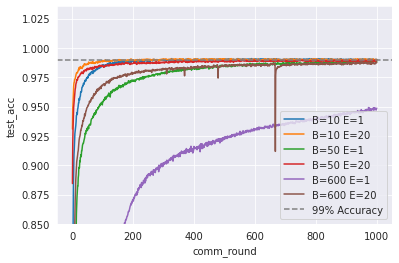

In [35]:
sns.lineplot(data=df_metrics[df_metrics['setting'] == 'IID'], x='comm_round', y='test_acc', hue="label")
plt.axhline(y=0.99, color='grey', linestyle='--', label = "99% Accuracy")
plt.ylim(0.85, None)
plt.legend(loc='lower right')
plt.show()

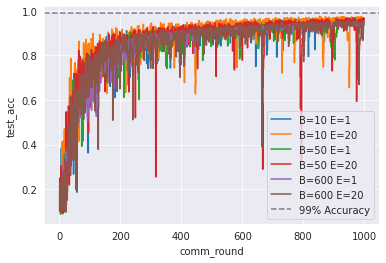

In [40]:
sns.lineplot(data=df_metrics[df_metrics['setting'] == 'NONIID'], x='comm_round', y='test_acc', hue="label", drawstyle='steps-pre')
plt.axhline(y=0.99, color='grey', linestyle='--', label = "99% Accuracy")
# plt.ylim(0.45, None)
plt.legend(loc='lower right')
plt.show()